<a href="https://colab.research.google.com/github/afrahhassan/afrahhassan/blob/main/Copy_of_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
# <div align="center"><font>  </font></div>
# <div align="center"><font> COSC 2793 Computational Machine Learning </font></div>
## <div align="center"> <font> Assignment 2: Machine Learning Project </font></div>
## <div align="center"> <font> S3930776 Afrah Hassan A Alshaikh Ali & S3569266 Chang Su </font></div>
---

In [2]:
#Import Libraries
import os
import csv
import zipfile
import pandas as pd
import cv2
import numpy as np
import PIL
import matplotlib.pyplot as plt

Workflow
We need to follow the below 4 steps to build our traffic sign classification model:

Dataset exploration
CNN model building
Model training and validation
Model testing
https://www.analyticsvidhya.com/blog/2021/12/traffic-signs-recognition-using-cnn-and-keras-in-python/


# **1. Load and Preprocess the Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.listdir('/content/drive/MyDrive/Assignment2')

['assignment2_PG.pdf',
 'COSC2673_2793_A2_EOI_.docx',
 'assignment2.ipynb',
 'trafficsigns_dataset.zip',
 'trafficsigns_dataset',
 'shape.csv',
 'type.csv']

In [5]:
!cp -r "/content/drive/MyDrive/Assignment2" .

In [6]:
zip_file_path = '/content/drive/My Drive/Assignment2/trafficsigns_dataset.zip'
extract_to_path = '/content/trafficsigns_dataset'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
print("Extraction completed!")

Extraction completed!


Load the images and corresponding labels from the dataset.

### Export shape to csv


In [58]:
import os
import csv

output_csv = '/content/drive/My Drive/Assignment2/shape.csv'

entry_count = 0

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'class'])

    for root, dirs, files in os.walk(extract_to_path ):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                class_name = os.path.basename(os.path.dirname(root))
                writer.writerow([full_path, class_name])
                entry_count += 1  # Increment the counter for each image processed

print(f"CSV file has been created successfully with {entry_count} entries.")


CSV file has been created successfully with 3699 entries.


In [59]:
import os
import csv

output_csv = '/content/drive/My Drive/Assignment2/type.csv'

entry_count = 0

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'class'])

    for root, dirs, files in os.walk(extract_to_path ):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                class_name = os.path.basename(os.path.dirname(root))
                writer.writerow([full_path, class_name])
                entry_count += 1  # Increment the counter for each image processed

print(f"CSV file has been created successfully with {entry_count} entries.")

CSV file has been created successfully with 3699 entries.


In [60]:
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder

# Load the original CSV file
csv_path = '/content/drive/My Drive/Assignment2/type.csv'
data = pd.read_csv(csv_path)

# Encode the 'class' column
label_encoder = LabelEncoder()
data['class_encoded'] = label_encoder.fit_transform(data['class'])

# Convert images to arrays
image_arrays = []
for image_path in data['image_path']:
    with Image.open(image_path) as img:
        # Since your images are grayscale and 28x28, no need to convert to RGB
        img_array = np.array(img.convert('L'))  # 'L' mode is for grayscale images
        image_arrays.append(img_array)

# Create a DataFrame from the image arrays
image_df = pd.DataFrame({'image_path': data['image_path'], 'image_array': image_arrays})

# Merge the two DataFrames
merged_data = pd.merge(data, image_df, on='image_path')

# Display or save the result
print(merged_data.head())
# Optionally save the merged DataFrame to a new CSV file
# merged_data.to_csv('/content/drive/My Drive/Assignment2/merged_data.csv', index=False)



                                          image_path class  class_encoded  \
0  /content/trafficsigns_dataset/trafficsigns_dat...   hex              1   
1  /content/trafficsigns_dataset/trafficsigns_dat...   hex              1   
2  /content/trafficsigns_dataset/trafficsigns_dat...   hex              1   
3  /content/trafficsigns_dataset/trafficsigns_dat...   hex              1   
4  /content/trafficsigns_dataset/trafficsigns_dat...   hex              1   

                                         image_array  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1  [[69, 70, 68, 67, 64, 63, 59, 59, 54, 55, 59, ...  
2  [[24, 27, 30, 34, 36, 38, 40, 42, 42, 42, 40, ...  
3  [[176, 119, 127, 130, 128, 145, 135, 115, 158,...  
4  [[53, 48, 41, 72, 58, 77, 60, 57, 60, 65, 66, ...  


# ** i belive you can use this to start train the machine, wish you the best ;)**

In [61]:
#save data to csv

merged_csv_path = '/content/drive/My Drive/Assignment2/merged_data.csv'
merged_data.to_csv(merged_csv_path, index=False)  # Set index=False to exclude row indices from the file

print(f"The merged data has been successfully saved to {merged_csv_path}.")


The merged data has been successfully saved to /content/drive/My Drive/Assignment2/merged_data.csv.


### Export type to csv

In [40]:
# Load the data from the CSV file
data_1 = pd.read_csv('/content/drive/My Drive/Assignment2/shape.csv')
data_1.head()

,image_path,class
0,/content/trafficsigns_dataset/trafficsigns_dat...,hex
1,/content/trafficsigns_dataset/trafficsigns_dat...,hex
2,/content/trafficsigns_dataset/trafficsigns_dat...,hex
3,/content/trafficsigns_dataset/trafficsigns_dat...,hex
4,/content/trafficsigns_dataset/trafficsigns_dat...,hex


In [41]:
# Find the number of unique types/classes
num_shapes = data_1['class'].nunique()

# Get the count of each unique type/class
shape_counts = data_1['class'].value_counts()

print("Number of unique shapes:", num_shapes)
print("unique shapes:", shape_counts)


Number of unique shapes: 5
unique shapes: class
round       1760
triangle     926
square       688
diamond      282
hex           43
Name: count, dtype: int64


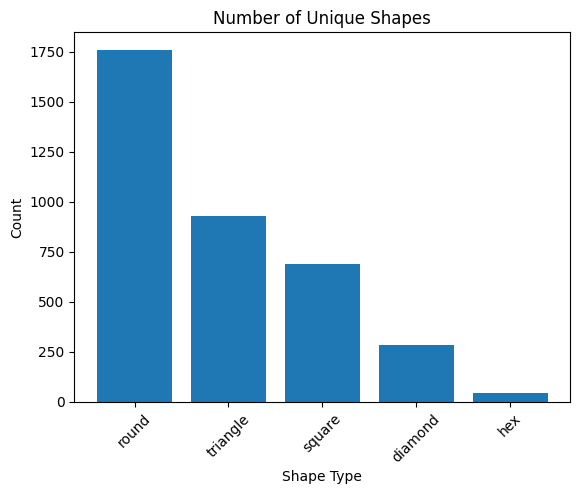

In [42]:
#Plot the shapes
# Import necessary libraries
import matplotlib.pyplot as plt

# Extract data for plotting
class_names = shape_counts.index.to_list()
class_counts = shape_counts.to_numpy()

# Create a bar plot
plt.bar(class_names, class_counts)

# Add title and labels
plt.title("Number of Unique Shapes")
plt.xlabel("Shape Type")
plt.ylabel("Count")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [43]:
# Load the data from the CSV file
data_2 = pd.read_csv('/content/drive/My Drive/Assignment2/type.csv')
data_2.head()


,image_path,class
0,/content/trafficsigns_dataset/trafficsigns_dat...,stop
1,/content/trafficsigns_dataset/trafficsigns_dat...,stop
2,/content/trafficsigns_dataset/trafficsigns_dat...,stop
3,/content/trafficsigns_dataset/trafficsigns_dat...,stop
4,/content/trafficsigns_dataset/trafficsigns_dat...,stop


In [ ]:
# Find the number of unique types/classes
num_types = data_2['class'].nunique()
# Get the count of each unique type/class
type_counts = data_2['class'].value_counts()

print("Number of unique types:", num_types)
print("unique types:", type_counts)

In [ ]:
#Plot the types
# Import necessary libraries
import matplotlib.pyplot as plt

# Extract data for plotting
class_names = type_counts.index.to_list()
class_counts = type_counts.to_numpy()

# Create a bar plot
plt.bar(class_names, class_counts)

# Add title and labels
plt.title("Number of Unique Types per Shape")
plt.xlabel("Type")
plt.ylabel("Count")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
print('The dataset has {} shapes'.format(len(data_1['class'].unique())))
print('The dataset has {} types'.format(len(data_2['class'].unique())))

EDA

In [ ]:
data_1.info()

In [ ]:
data_2.info()

In [1]:
import cv2
import numpy as np
import pandas as pd
import os

def load_images_from_csv(csv_file_path, image_folder, target_size):
    # Read the CSV file containing image paths
    data = pd.read_csv(csv_file_path)

    image_arrays = []
    image_paths = []  # List to store the paths of the images
    for index, row in data.iterrows():
        # Construct the full path to the image file
        full_path = os.path.join(image_folder, row['image_path'])

        # Load the image using OpenCV
        image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

        # Check if the loaded image is empty
        if image is None:
            continue

        # Resize the image to the target size
        resized_image = cv2.resize(image, target_size)

        # Convert the resized image to a numpy array
        image_array = np.array(resized_image)

        # Append the image array and the path to their respective lists
        image_arrays.append(image_array)
        image_paths.append(full_path)  # Append the path

    # Convert the list of arrays to a numpy array
    image_arrays = np.array(image_arrays)

    return image_arrays, image_paths  # Return both arrays and paths

# Example usage
csv_file_path = "/content/drive/My Drive/Assignment2/type.csv"
image_folder = "/content/drive/My Drive/Assignment2"
target_size = (28, 28)

image_arrays, image_paths = load_images_from_csv(csv_file_path, image_folder, target_size)
print("Shape of the numpy array:", image_arrays.shape)
print("Paths of the images:", image_paths)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Assignment2/type.csv'

In [51]:
import cv2
import numpy as np
import pandas as pd
import os

def load_images_from_csv(csv_file_path, image_folder, target_size):
    # Read the CSV file containing image paths
    data = pd.read_csv(csv_file_path)

    image_arrays = []
    for index, row in data.iterrows():
        # Construct the full path to the image file
        full_path = os.path.join(image_folder, row['image_path'])

        # Load the image using OpenCV
        image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

        # Check if the loaded image is empty
        if image is None:
            continue

        # Resize the image to the target size
        resized_image = cv2.resize(image, target_size)

        # Convert the resized image to a numpy array
        image_array = np.array(resized_image)

        # Append the image array to the list
        image_arrays.append(image_array)

    # Convert the list of arrays to a numpy array
    image_arrays = np.array(image_arrays)

    return image_arrays

# Example usage
csv_file_path = "/content/drive/My Drive/Assignment2/shape.csv"
image_folder = "/content/drive/My Drive/Assignment2"
target_size = (28, 28)

image_arrays_2 = load_images_from_csv(csv_file_path, image_folder, target_size)
print("Shape of the numpy array:", image_arrays.shape)

Shape of the numpy array: (3699, 28, 28)


Convert images to numbers


In [ ]:
# from sklearn.preprocessing import LabelEncoder

# # Create a LabelEncoder object
# encoder = LabelEncoder()

# # Encode the "class" column in shape.csv
# main['class'] = encoder.fit_transform(main['class'])


# # Now both "shape" and "type" columns are encoded


In [ ]:
# from sklearn.preprocessing import LabelEncoder
# # Create separate LabelEncoder objects for shape and type
# shape_encoder = LabelEncoder()
# type_encoder = LabelEncoder()

# # Encode the shape and type columns
# data_1['shape_encoded'] = shape_encoder.fit_transform(data_1['class'])  #7398
# data_2['type_encoded'] = type_encoder.fit_transform(data_2['class'])  #7398

# # Now you can train your models using the encoded columns

# **2. Split the Data**

# **3. Choose a Model**


Baseline Model


# **4. Train the Model**


# **5. Evaluate the Model**